# Data Exploration

Description: https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, log_loss

%matplotlib inline

In [2]:
import warnings;
with warnings.catch_warnings():
    warnings.simplefilter("ignore"); 

In [3]:
train_df = pd.read_json("train.json")
test_df = pd.read_json("test.json") 

In [4]:
len(train_df), len(test_df)

(49352, 74659)

In [5]:
train_df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street


In [6]:
print "Min: ", train_df.price.min()
print "Max: ", train_df.price.max()
print "Mean:", train_df.price.mean()
print "Standard deviation: ", train_df.price.std()

Min:  43
Max:  4490000
Mean: 3830.1740355
Standard deviation:  22066.8658847


In [7]:
train_df[train_df.price==43]

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
53144,1.0,0,64f8e51f01a36ab0cd55fe9de2381306,2016-05-24 05:24:56,<p><a website_redacted,Madison,"[Doorman, Elevator, High Speed Internet]",low,40.712,7060255,-73.9971,29ebd2f6553fbe12706a006a97349dd6,[],43,60 Madison


In [8]:
print "Min: ", train_df.created.min()
print "Max: ", train_df.created.max()

Min:  2016-04-01 22:12:41
Max:  2016-06-29 21:41:47


In [9]:
train_df.bathrooms.value_counts()

1.0     39422
2.0      7660
3.0       745
1.5       645
0.0       313
2.5       277
4.0       159
3.5        70
4.5        29
5.0        20
5.5         5
6.0         4
6.5         1
10.0        1
7.0         1
Name: bathrooms, dtype: int64

In [10]:
train_df.bedrooms.value_counts()

1    15752
2    14623
0     9475
3     7276
4     1929
5      247
6       46
8        2
7        2
Name: bedrooms, dtype: int64

In [11]:
features_list = []
for i in range(len(train_df)):
    alist = train_df.features.values[i]
    for x in alist:
        features_list.append(x)

In [12]:
len(features_list), len(set(features_list))

(267906, 1556)

In [13]:
sorted(set(features_list))

[u'!!!!LOW FEE!!!!',
 u'$1000. Move-in Visa Giftcard will be handed to new tenants upon rental lease signing',
 u'$1500. Move-in Visa Giftcard will be handed to new tenants upon rental lease signing',
 u'$250 Security Deposit',
 u'$250 application fee with background and credit check. Board interview and approval.',
 u'$500 Security Deposit',
 u'$600 gift card for Move-ins prior to June 19',
 u'& ATM machine on-site',
 u'* MARVELOUS MIDTOWN GEM * SPACIOUS SUNDRENCHED STUDIO * STUNNING PREWAR DETAILS * CATS OK **',
 u"** ALL BRAND NEW NO FEE! * EXPANSIVE 2BR McMANSION * PRIVATE TERRACE * COOK'S SS KITCHEN * ELEV/LNDRY BLDG * 3 BLKS TO L TRAIN **",
 u"** BKLYN'S FINEST! * MASSIVE TRUE 2BR * COURTYARD * FULLY RENOVATED * 2 BLKS TO BEDFORD L STOP **",
 u"** BRAND SPANKIN' NEW * OVERSIZED 3BR HOME * WASHER/DRYER * SS KITCHEN w/ISLAND * HEART OF DESIRABLE SOHO **",
 u"** BRING UR BBQ! * SPRAWLING 2BR HOME * HUGE REAR TERRACE * MODERN EVERYTHING * CHEF'S KITCHEN * ALL NEW **",
 u'** BROWNSTON

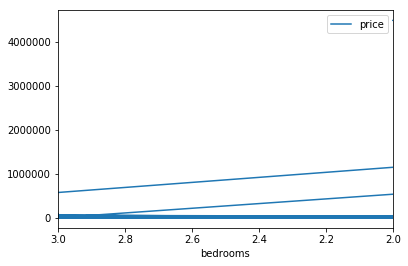

In [14]:
train_df.plot(x='bedrooms', y='price', style='-')

Seems unrelevant: building_id, created, manager_id.

Let's convert some features to more useful:

In [15]:
def add_features(df):
    df['num_photos'] = df['photos'].apply(len)
    df['num_features'] = df['features'].apply(len)
    df['description_size'] = df['description'].apply(lambda x: len(x.split(" ")))
    df['created'] = pd.to_datetime(df['created'])
    df['created_day'] = df['created'].dt.day
    df['created_month'] = df['created'].dt.month
    df['hod'] = df['created'].dt.hour
    df['dow'] = df['created'].dt.dayofweek

In [16]:
add_features(train_df)
add_features(test_df)

In [17]:
train_df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,photos,price,street_address,num_photos,num_features,description_size,created_day,created_month,hod,dow
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,...,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,5,0,95,24,6,7,4
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,11,5,9,12,6,12,6
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,...,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,8,4,94,17,4,3,6


https://www.kaggle.com/shubh24/two-sigma-connect-rental-listing-inquiries/neighborhood-as-factor-reverse-geocoding - NOT ALLOWED in kaggle

In [18]:
# https://github.com/thampiman/reverse-geocoder
import reverse_geocoder as rg

In [19]:
train_coordinates = train_df[["listing_id", "latitude", "longitude"]]

# Reverse Geocoder takes a list of tuples (of latitude and longitude) as its input.
lat_lon = []
listings = []

for i, j in train_coordinates.iterrows():
    lat_lon.append((j["latitude"], j["longitude"]))
    listings.append(int(j["listing_id"]))

In [20]:
results = rg.search(lat_lon)
# nbd = [[listings[i], results[i]['name']] for i in range(0, len(results))]

Loading formatted geocoded file...


In [21]:
# train_df['neighborhood']=''
for i in range(0, len(results)):
    train_df.loc[train_df['listing_id'] ==listings[i], 'neighborhood'] = results[i]['name']

In [22]:
train_df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,price,street_address,num_photos,num_features,description_size,created_day,created_month,hod,dow,neighborhood
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,...,3000,792 Metropolitan Avenue,5,0,95,24,6,7,4,Long Island City
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,5465,808 Columbus Avenue,11,5,9,12,6,12,6,Manhattan
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,...,2850,241 W 13 Street,8,4,94,17,4,3,6,New York City


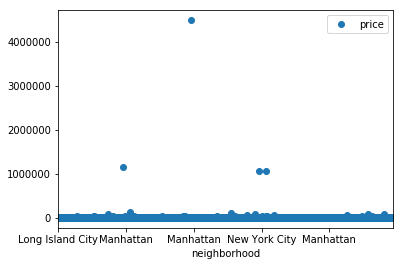

In [23]:
train_df.plot(x='neighborhood', y='price', style='o')

In [24]:
my_features = ["bathrooms", "bedrooms", "latitude", "longitude", "price", 
               "num_photos", "num_features", "description_size", "hod", "dow"]

X = train_df[my_features]
y = train_df["interest_level"]

X.head()

,bathrooms,bedrooms,latitude,longitude,price,num_photos,num_features,description_size,hod,dow
10,1.5,3,40.7145,-73.9425,3000,5,0,95,7,4
10000,1.0,2,40.7947,-73.9667,5465,11,5,9,12,6
100004,1.0,1,40.7388,-74.0018,2850,8,4,94,3,6
100007,1.0,1,40.7539,-73.9677,3275,3,2,80,2,0
100013,1.0,4,40.8241,-73.9493,3350,3,1,68,1,3


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
%%time
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
print('LogisticRegression score: %f' % logistic.score(X_test, y_test))

LogisticRegression score: 0.684530
CPU times: user 815 ms, sys: 9.68 ms, total: 824 ms
Wall time: 821 ms


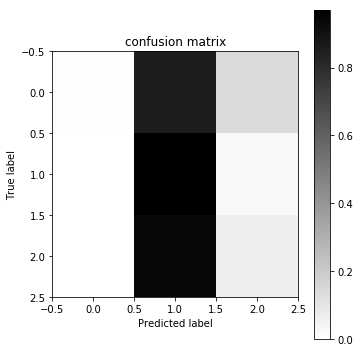

In [27]:
plt.figure(figsize=(5, 5))
cm = confusion_matrix(y_test, logistic.predict(X_test))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.binary)
plt.title("confusion matrix")
plt.colorbar()
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('confusion_matrix.png', dpi=200)

In [28]:
%%time
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)
print('RandomForestClassifier score: %f' % clf.score(X_test, y_test))

RandomForestClassifier score: 0.733259
CPU times: user 59 s, sys: 1.17 s, total: 1min
Wall time: 1min


In [29]:
y_prediction = clf.predict_proba(X_test)
log_loss(y_test, y_prediction)

0.61315712499301356

In [30]:
X = train_df[my_features]
y = clf.predict_proba(X)

In [31]:
labels2idx = {label: i for i, label in enumerate(clf.classes_)}
labels2idx

{u'high': 0, u'low': 1, u'medium': 2}

In [32]:
submission = pd.DataFrame()
submission["listing_id"] = train_df["listing_id"]
for label in ["high", "medium", "low"]:
    submission[label] = y[:, labels2idx[label]]
submission.to_csv("submission.csv", index=False)

In [33]:
submission.head()

,listing_id,high,medium,low
10,7211212,0.018,0.729,0.253
10000,7150865,0.013,0.106,0.881
100004,6887163,0.663,0.084,0.253
100007,6888711,0.000,0.034,0.966
100013,6934781,0.013,0.191,0.796
